<a href="https://colab.research.google.com/github/shikarRajcomar-Engineer/Ensemble/blob/master/sample_pair_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Set up Tensorboard Logging**

In [ ]:
%load_ext tensorboard


# Clear any tensorflow logs from previous runs
!rm -rf ./logs/ 

**Import Dataset**

Datset are in the form of Numpy arrays


In [ ]:
import numpy as np 
from os import listdir
from os.path import isfile, join
import cv2
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import sys
import shutil
import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras import backend as K
import pandas as pd
from sklearn.metrics import classification_report
from numpy.random import seed
from matplotlib import pyplot
from numpy import expand_dims
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
import sklearn
import datetime, os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import datetime as datetime
import tensorflow
tensorflow.random.set_seed(1234)



path='/content/drive/My Drive/Datasets/'
Dataset='brain_tumor_dataset244'
batch_size=32


def load_data_training_and_test(datasetname):
        npzfile=np.load(path+datasetname+'training_data.npz')
        train=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'training_labels.npz')
        train_labels=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'testing_data.npz')
        test=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'testing_labels.npz')
        test_labels=npzfile['arr_0']    
        return (train,train_labels),(test,test_labels)

(x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset)


**Data Normalization**

In [ ]:
y_train=y_train.reshape(y_train.shape[0],1)
y_testing=y_testing.reshape(y_testing.shape[0],1)
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')
x_train/=255
x_test/=255
training_size=len(x_train)
test_size=len(y_testing)
classes = np.unique(y_train)
nClasses = len(classes)
num_classes = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)
img_rows=x_train[0].shape[0]
img_cols=x_train[1].shape[0]
input_shape=(img_rows,img_cols,3)
print(input_shape)
print(len(x_train))


Total number of outputs :  2
Output classes :  [0 1]
(244, 244, 3)
176


**Define Image generators**

In [ ]:
# datagen = ImageDataGenerator(channel_shift_range=0.2)
# val_datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen = ImageDataGenerator(horizontal_flip=True)
val_datagen = ImageDataGenerator(horizontal_flip=True)
# datagen = ImageDataGenerator(zoom_range=0.2,horizontal_flip=True,vertical_flip=True,rotation_range=0.2,channel_shift_range=0.2)
# val_datagen = ImageDataGenerator(zoom_range=0.2,horizontal_flip=True,vertical_flip=True,rotation_range=0.2,channel_shift_range=0.2)
# datagen = ImageDataGenerator(rotation_range=0.2)
# val_datagen = ImageDataGenerator(rotation_range=0.2)
# datagen = ImageDataGenerator(rescale=1./255)
# val_datagen = ImageDataGenerator(rescale=1./255)
# datagen = ImageDataGenerator(shear_range=0.2,horizontal_flip=True,vertical_flip=True,rotation_range=0.2,zoom_range=0.2)
# val_datagen = ImageDataGenerator(shear_range=0.2,horizontal_flip=True,vertical_flip=True,rotation_range=0.2,zoom_range=0.2)

**Call Back Function**

In [ ]:

earlystop=EarlyStopping(patience=20)
learning_rate_reduction=ReduceLROnPlateau(monitor='val_acc'
                                        ,patience=20
                                        ,verbose=1
                                        ,factor=0.5
                                        ,min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]



logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d%h$m%s"))
Logger=keras.callbacks.TensorBoard(log_dir=logdir,write_graph=True,histogram_freq=1)
print(logdir)

logs/20200531May$m1590950114


**CNN Architecture**

In [ ]:
# from keras.applications.vgg16 import VGG16
# # load the model
# model = VGG16()
# # summarize the model
# model.summary()

model=Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2))


model.add(Conv2D(224, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2))


model.add(Conv2D(192, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2))



model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dropout(0.3))
model.add(Dense(2))
model.add(Activation("softmax"))



optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# sparse_categorical_crossentropy

Logger=keras.callbacks.TensorBoard(log_dir=logdir,write_graph=True,histogram_freq=1)

print("Number of weights after calling the model:", len(model.weights)) 


Number of weights after calling the model: 10


**Pass images to the Model fit function in batches**

In [ ]:
train_generator = datagen.flow(x_train,y_train,batch_size=batch_size)

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow(x_test,y_testing,batch_size=batch_size)

**Fit Model**

In [ ]:
epochs=200

mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


# fit model
train_generator = datagen.flow(x_train,y_train,batch_size=batch_size)

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow(x_test,y_testing,batch_size=batch_size)

history = model.fit_generator(
      train_generator,
      epochs=epochs,
      validation_data=validation_generator,
      verbose=2,
      shuffle=True,
     callbacks=[earlystop, learning_rate_reduction,mc])

# print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(
# history.history['val_loss'][-1], 
# history.history['val_accuracy'][-1]))

saved_model = load_model('best_model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(x_test, y_testing, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

his_df=pd.DataFrame(history.history)

predicted_classes = model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)


target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_testing, predicted_classes, target_names=target_names))

Epoch 1/200
 - 1s - loss: 0.1148 - accuracy: 0.9657 - val_loss: 1.0108 - val_accuracy: 0.7067

Epoch 00001: val_accuracy improved from -inf to 0.70667, saving model to best_model.h5
Epoch 2/200


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 1s - loss: 0.0967 - accuracy: 0.9714 - val_loss: 1.5389 - val_accuracy: 0.7200

Epoch 00002: val_accuracy improved from 0.70667 to 0.72000, saving model to best_model.h5
Epoch 3/200
 - 1s - loss: 0.1184 - accuracy: 0.9543 - val_loss: 1.9611 - val_accuracy: 0.7200

Epoch 00003: val_accuracy did not improve from 0.72000
Epoch 4/200
 - 1s - loss: 0.0838 - accuracy: 0.9771 - val_loss: 0.5555 - val_accuracy: 0.6933

Epoch 00004: val_accuracy did not improve from 0.72000
Epoch 5/200
 - 1s - loss: 0.1112 - accuracy: 0.9657 - val_loss: 1.4344 - val_accuracy: 0.7067

Epoch 00005: val_accuracy did not improve from 0.72000
Epoch 6/200
 - 1s - loss: 0.0956 - accuracy: 0.9714 - val_loss: 2.1643 - val_accuracy: 0.6800

Epoch 00006: val_accuracy did not improve from 0.72000
Epoch 7/200
 - 1s - loss: 0.0939 - accuracy: 0.9657 - val_loss: 0.9356 - val_accuracy: 0.7067

Epoch 00007: val_accuracy did not improve from 0.72000
Epoch 8/200
 - 1s - loss: 0.0870 - accuracy: 0.9829 - val_loss: 2.0536 - val_

**Model Evaluate**

In [ ]:
score = model.evaluate(x_test, y_testing)  
y_val_cat_prob=model.predict(x_test)

48/48 [==============================] - 0s 2ms/step


**Plot the training and validation accuracy**

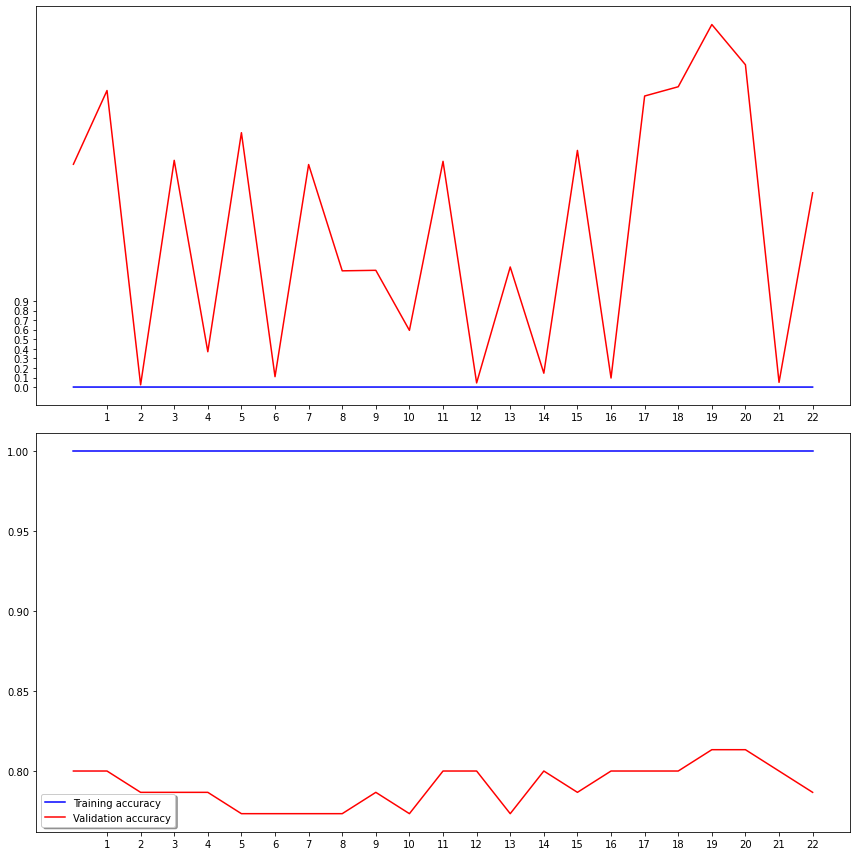

In [ ]:
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
  ax1.plot(history.history['loss'], color='b', label="Training loss")
  ax1.plot(history.history['val_loss'], color='r', label="validation loss")
  ax1.set_xticks(np.arange(1, len(history.history['loss']), 1))
  ax1.set_yticks(np.arange(0, 1, 0.1))

  ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
  ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
  ax2.set_xticks(np.arange(1, len(history.history['loss']), 1))
  legend = plt.legend(loc='best', shadow=True)
  plt.tight_layout()
  plt.show()

**Calculate roc curve and area under curve**

In [ ]:
fpr , tpr , thresholds = roc_curve ( y_testing , y_val_cat_prob)
def plot_roc_curve(fpr,tpr): 
    plt.plot(fpr,tpr) 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()    
plot_roc_curve (fpr,tpr)


auc_score=roc_auc_score(y_testing,y_val_cat_prob)
print(auc_score)

**Confusion Matrix**

In [ ]:
his_df=pd.DataFrame(history.history)

predicted_classes = model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)


target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_testing, predicted_classes, target_names=target_names))







              precision    recall  f1-score   support

     Class 0       0.54      0.70      0.61        10
     Class 1       0.91      0.84      0.88        38

    accuracy                           0.81        48
   macro avg       0.73      0.77      0.74        48
weighted avg       0.84      0.81      0.82        48



**Save** **Model** 

In [ ]:
%tensorboard --port=5036 --logdir $logdir

In [ ]:

model.save('/content/drive/My Drive/Tensorflow/No Aug Path.h5')

In [ ]:
!kill 606

In [ ]:


def train_on_x_samples( batchsize=30, steps=2000):
    validation_generator = val_datagen.flow(x_test,y_testing,batch_size=batch_size)

    train_generator = datagen.flow(x_train,y_train,batch_size=batch_size)
    

    hist_n_samples = model.fit_generator(
                train_generator,
                steps_per_epoch=steps,
                epochs=epochs,
                verbose=2,
                callbacks=[earlystop, learning_rate_reduction],
                validation_data=validation_generator,
                shuffle=True
    )
    return hist_n_samples


hist_one_sample = train_on_x_samples(1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(
hist_one_sample.history['val_loss'][-1], 
hist_one_sample.history['val_acc'][-1]))


hist_ten_samples = train_on_x_samples(10)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(
hist_ten_samples.history['val_loss'][-1], 
hist_ten_samples.history['val_acc'][-1]))

hist_hundred_samples = train_on_x_samples(100)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(
hist_hundred_samples.history['val_loss'][-1], 
hist_hundred_samples.history['val_acc'][-1]))

In [ ]:
import numpy as np 
from os import listdir
from os.path import isfile, join
import cv2
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import sys
import shutil
import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras import backend as K
import pandas as pd
from sklearn.metrics import classification_report
from numpy.random import seed
from matplotlib import pyplot
from numpy import expand_dims
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
import sklearn
import datetime, os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import datetime as datetime
import tensorflow
# tensorflow.random.set_seed(1234)
import random



path='/content/drive/My Drive/Experiment 1/'
Dataset='vertical_flip=True244'
batch_size=8


def load_data_training_and_test(datasetname):
        npzfile=np.load(path+datasetname+'training_data.npz')
        train=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'training_labels.npz')
        train_labels=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'testing_data.npz')
        test=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'testing_labels.npz')
        test_labels=npzfile['arr_0']    
        return (train,train_labels),(test,test_labels)

(x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset)

y_train=y_train.reshape(y_train.shape[0],1)
y_testing=y_testing.reshape(y_testing.shape[0],1)
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')
x_train/=255
x_test/=255
training_size=len(x_train)
test_size=len(y_testing)
classes = np.unique(y_train)
nClasses = len(classes)
num_classes = len(classes)
img_rows=x_train[0].shape[0]
img_cols=x_train[1].shape[0]
input_shape=(img_rows,img_cols,3)

i=0
for i in range(3):
    datagen = ImageDataGenerator(horizontal_flip=True)
    val_datagen = ImageDataGenerator(horizontal_flip=True)
    # datagen = ImageDataGenerator(vertical_flip=True)
    # val_datagen = ImageDataGenerator(vertical_flip=True)

    # datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True)
    # val_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True)
    # datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    # val_datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    # datagen = ImageDataGenerator(rescale=1./255)
    # val_datagen = ImageDataGenerator(rescale=1./255)
    # datagen = ImageDataGenerator(shear_range=0.2,horizontal_flip=True,vertical_flip=True,rotation_range=0.2,zoom_range=0.2)
    # val_datagen = ImageDataGenerator(shear_range=0.2,horizontal_flip=True,vertical_flip=True,rotation_range=0.2,zoom_range=0.2)

    epochs=200

    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


    # fit model
    train_generator = datagen.flow(x_train,y_train,batch_size=batch_size)

    # Flow validation images in batches of 20 using val_datagen generator
    validation_generator = val_datagen.flow(x_test,y_testing,batch_size=batch_size)

    history = model.fit_generator(
          train_generator,
          epochs=epochs,
          validation_data=validation_generator,
          verbose=0,
          shuffle=True,
        callbacks=[es,mc])

    # print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(
    # history.history['val_loss'][-1], 
    # history.history['val_accuracy'][-1]))

    
    # evaluate the model
    _, train_acc = model.evaluate(x_train, y_train, verbose=0)
    _, test_acc = model.evaluate(x_test, y_testing, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    predicted_classes = model.predict(x_test)

    his_df=pd.DataFrame(history.history)

    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)


    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    print(pd.DataFrame(report_dict))
    i+=1
    if i==3:
      break

Epoch 00029: early stopping
Train: 1.000, Test: 0.773
             Class 0    Class 1  accuracy  macro avg  weighted avg
precision   0.761905   0.777778  0.773333   0.769841      0.771852
recall      0.571429   0.893617  0.773333   0.732523      0.773333
f1-score    0.653061   0.831683  0.773333   0.742372      0.764998
support    28.000000  47.000000  0.773333  75.000000     75.000000
Epoch 00022: early stopping
Train: 1.000, Test: 0.747
             Class 0    Class 1  accuracy  macro avg  weighted avg
precision   0.736842   0.750000  0.746667   0.743421      0.745088
recall      0.500000   0.893617  0.746667   0.696809      0.746667
f1-score    0.595745   0.815534  0.746667   0.705639      0.733479
support    28.000000  47.000000  0.746667  75.000000     75.000000


KeyboardInterrupt: ignored

In [ ]:
a=pd.DataFrame(report_dict)
print(a['Class 0'][0])
print(a['Class 1'][0])

0.4117647058823529
0.9032258064516129


In [ ]:
import numpy as np 
from os import listdir
from os.path import isfile, join
import cv2
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import sys
import shutil
import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras import backend as K
import pandas as pd
from sklearn.metrics import classification_report
from numpy.random import seed
from matplotlib import pyplot
from numpy import expand_dims
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
import sklearn
import datetime, os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import datetime as datetime
import tensorflow
tensorflow.random.set_seed(1234)



path='/content/drive/My Drive/Datasets/'
Dataset='Original244'
batch_size=32
imagex=[]
labx=[]
imagey=[]
laby=[]
def load_data_training_and_test(datasetname):
        npzfile=np.load(path+datasetname+'training_data.npz')
        train=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'training_labels.npz')
        train_labels=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'testing_data.npz')
        test=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'testing_labels.npz')
        test_labels=npzfile['arr_0']    
        return (train,train_labels),(test,test_labels)

(x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset)




import random
a=0
if y_train[0]==1:
  for i in enumerate(x_train):
      n=random. randint(1,90)

      print
      nn=random. randint(1,90)
      a=(x_train[n])
      print(y_train[n])
      b=(x_train[nn])
      print(y_train[nn])

      img_a_array = np.asarray(a)
      img_b_array = np.asarray(b)

      # mix two images
      mean_img = np.mean([img_a_array, img_b_array], axis=0)
      img = (np.uint8(mean_img))
      imagex.append(img)
      labx.append(1)
      pyplot.imshow(img)
      pyplot.show()
      a=+1
    if a==2: 
        break




Using TensorFlow backend.


1
1


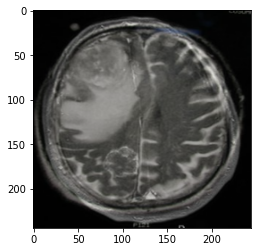

1
1


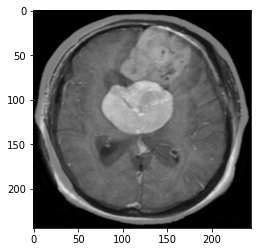

1
1


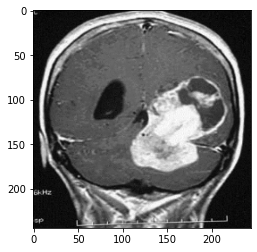

1
1


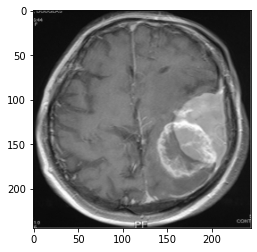

1
1


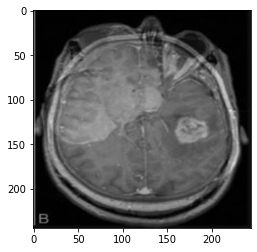

1
1


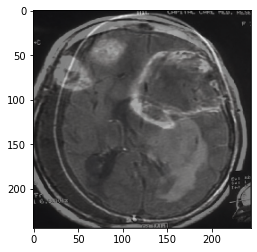

1
1


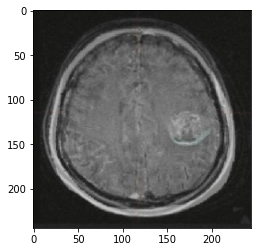

1
1


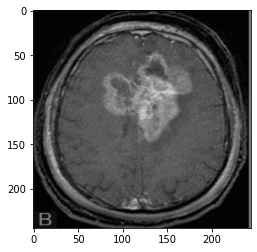

1
1


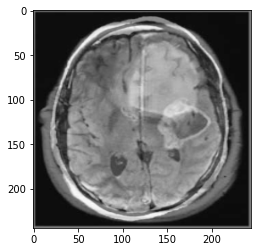

1
1


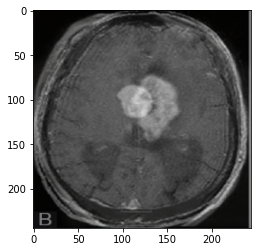

1
1


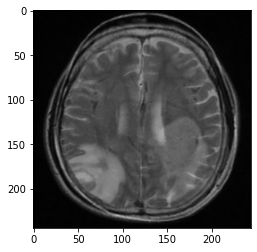

1
1


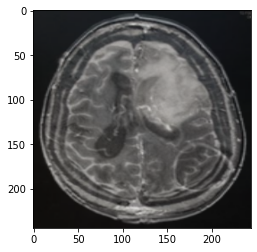

1
1


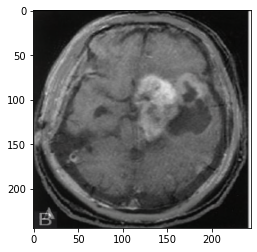

1
1


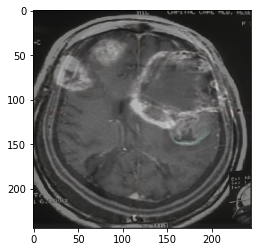

1
1


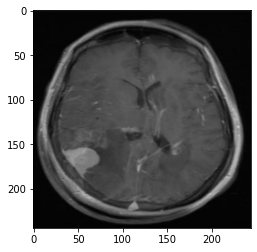

1
1


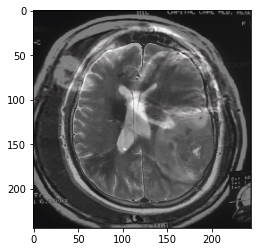

1
1


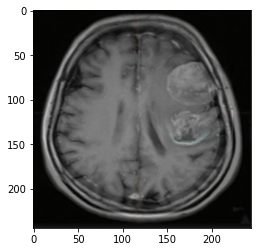

1
1


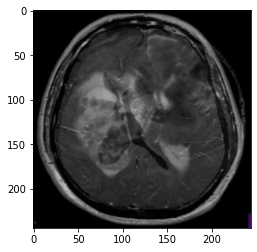

1
1


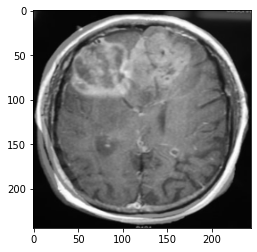

1
1


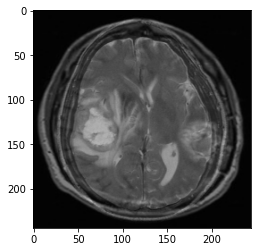

1
1


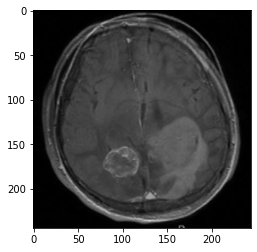

1
1


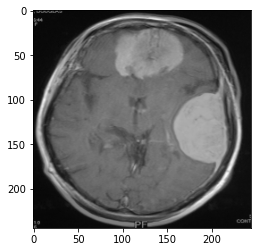

1
1


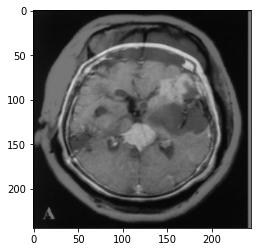

1
1


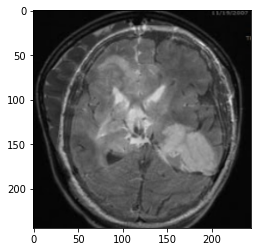

1
1


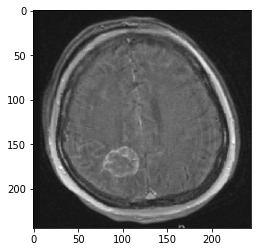

1
1


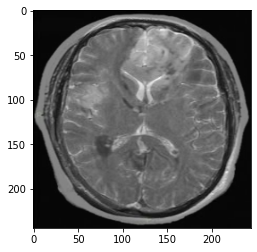

1
1


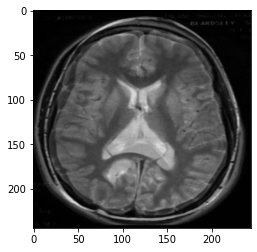

1
1


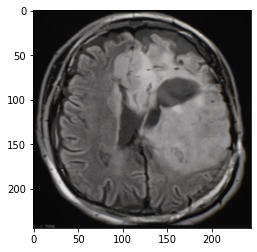

1
1


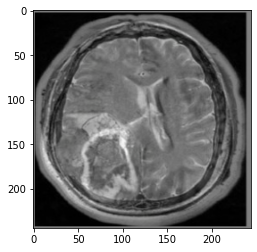

1
1


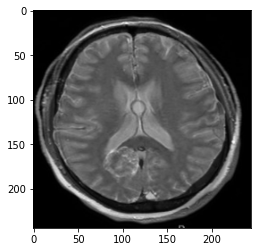

1
1


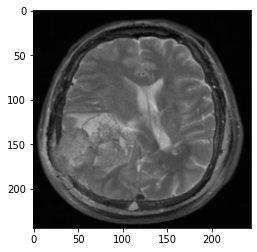

1
1


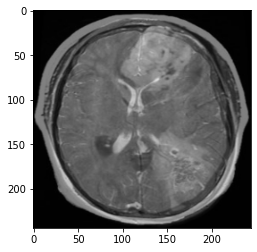

1
1


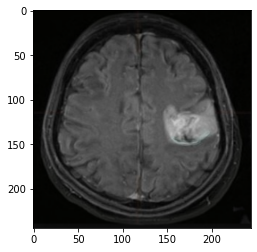

1
1


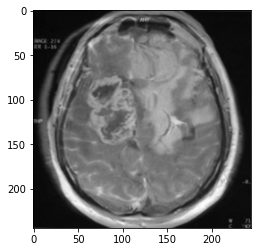

1
1


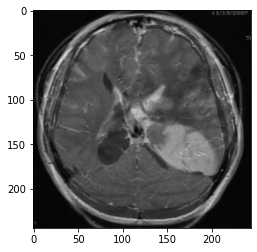

1
1


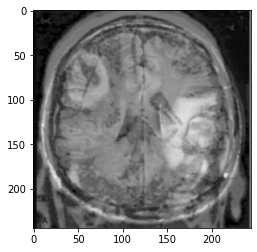

1
1


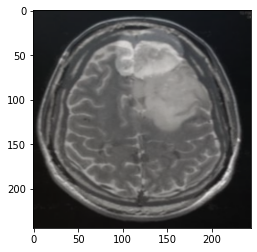

1
1


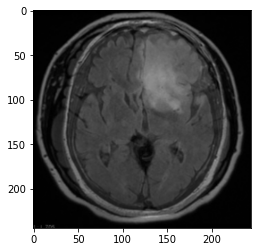

1
1


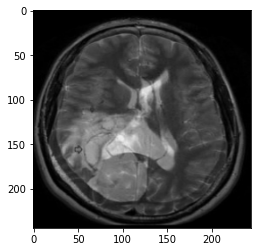

1
1


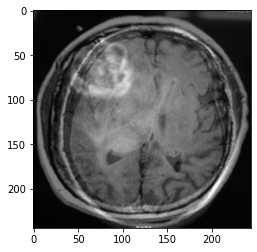

1
1


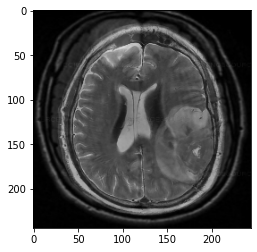

1
1


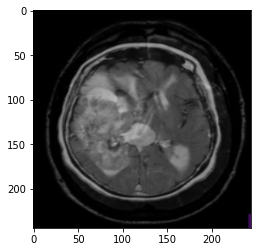

1
1


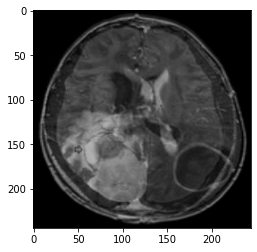

1
1


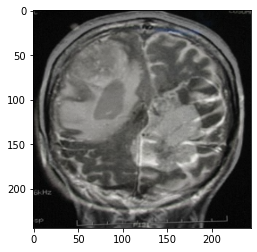

1
1


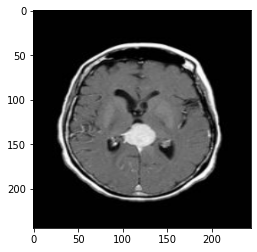

1
1


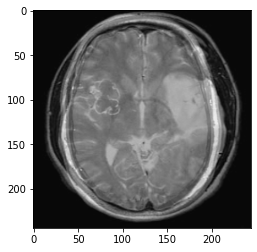

1
1


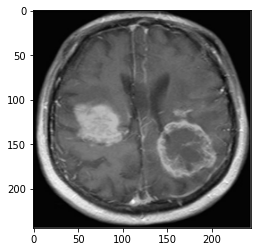

1
1


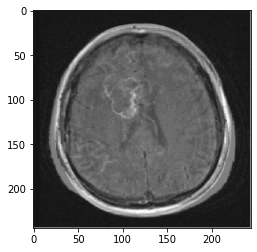

1
1


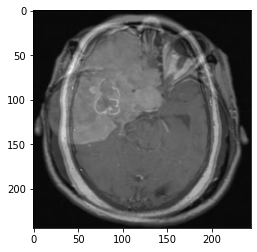

1
1


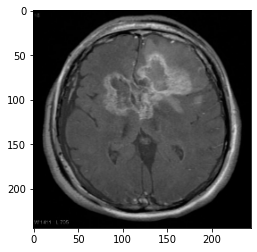

1
1


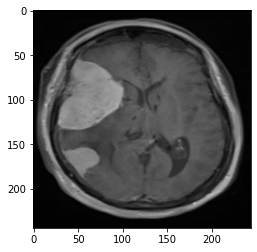

1
1


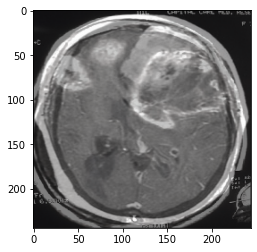

1
1


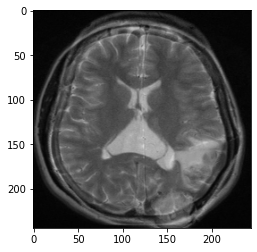

1
1


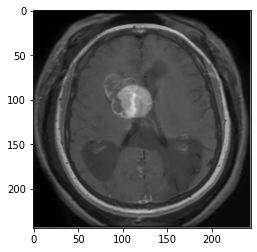

1
1


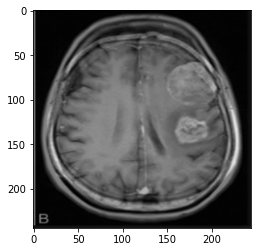

1
1


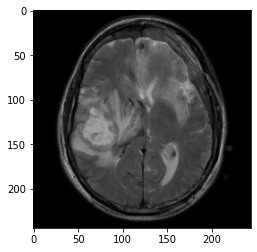

1
1


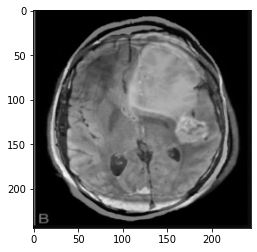

1
1


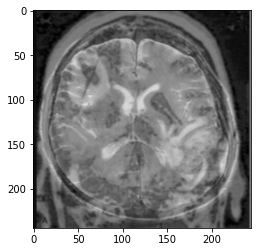

1
1


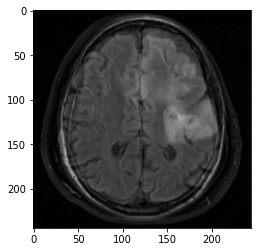

1
1


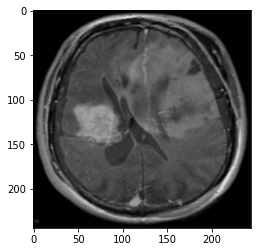

1
1


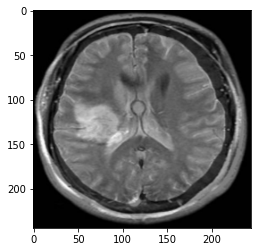

1
1


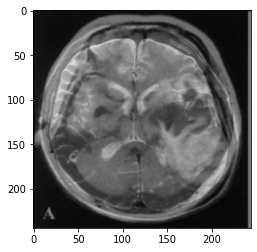

1
1


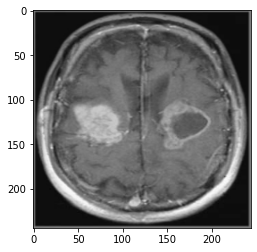

1
1


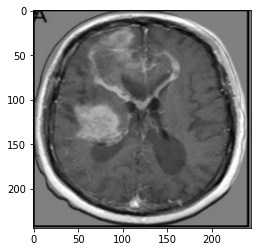

1
1


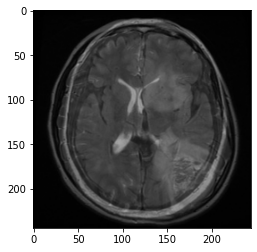

1
1


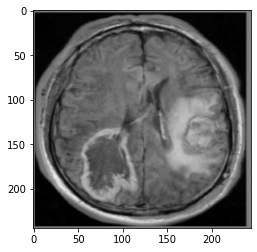

1
1


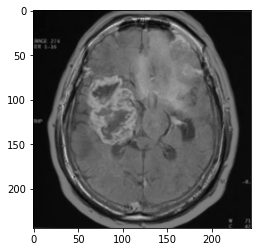

1
1


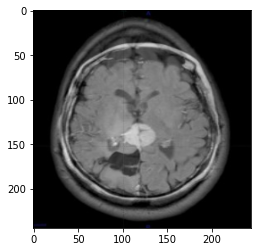

1
1


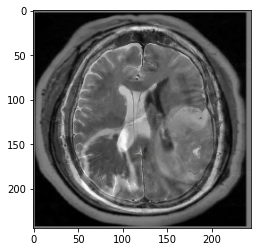

1
1


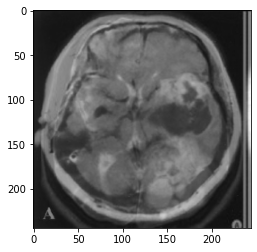

1
1


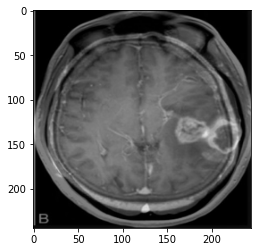

1
1


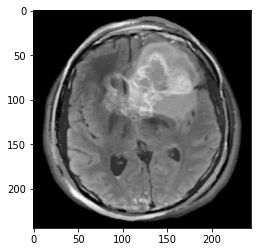

1
1


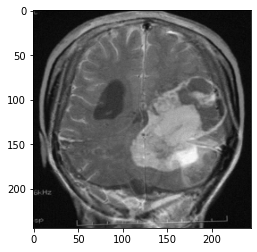

1
1


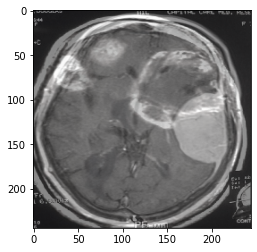

1
1


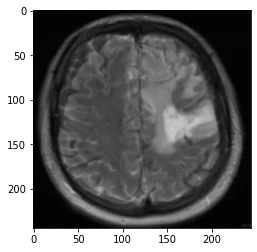

1
1


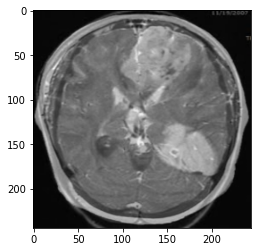

1
1


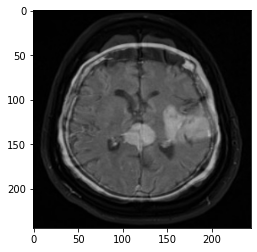

1
1


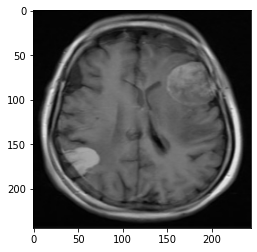

1
1


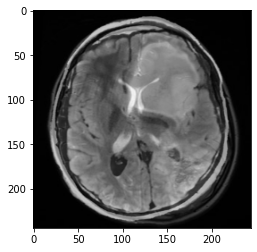

1
1


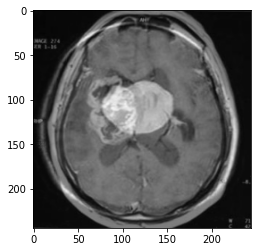

1
1


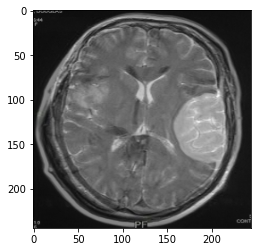

1
1


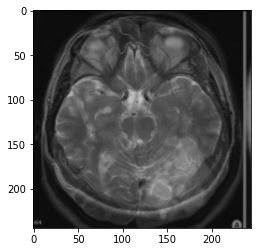

1
1


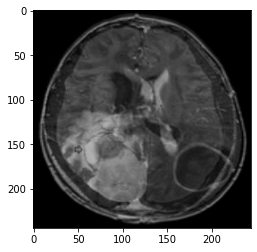

1
1


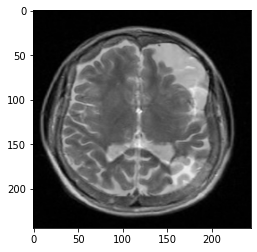

1
1


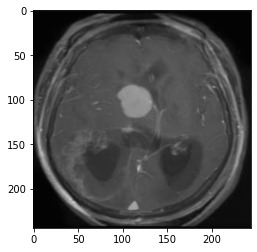

1
1


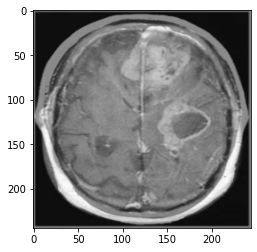

1
1


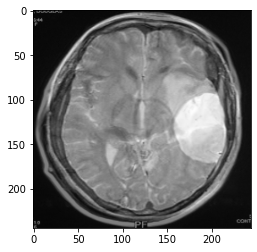

1
1


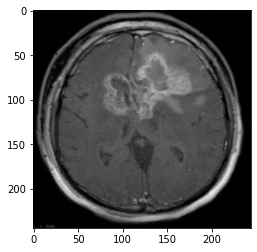

1
1


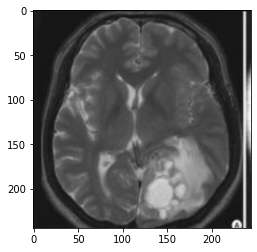

1
1


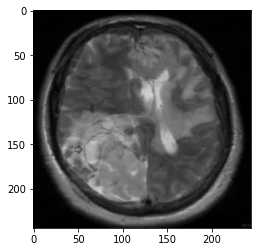

1
1


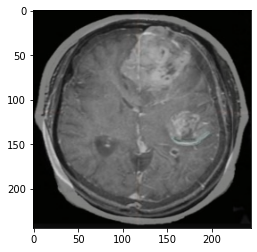

1
1


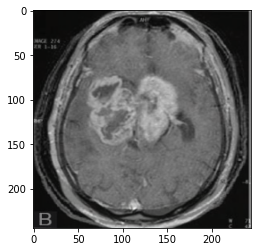

1
1


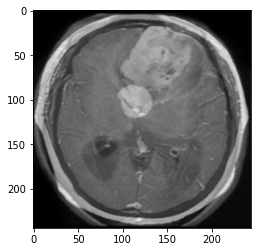

1
1


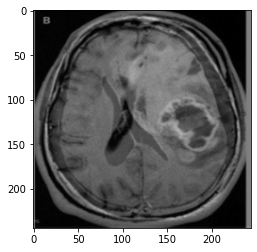

1
1


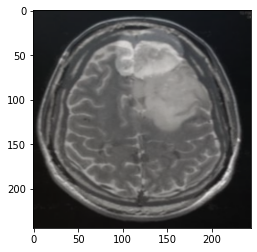

1
1


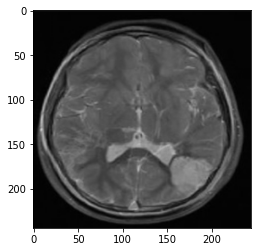

1
1


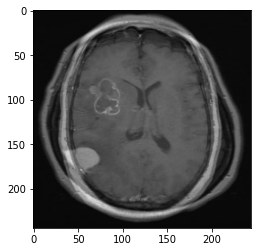

1
1


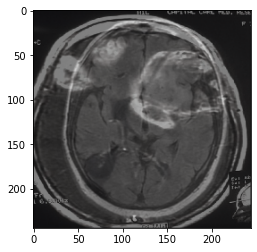

1
1


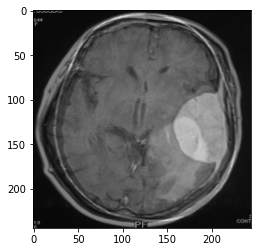

1
1


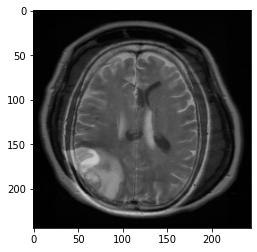

1
1


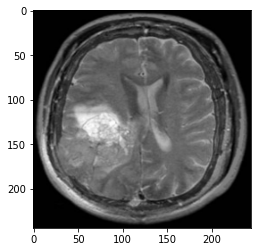

1
1


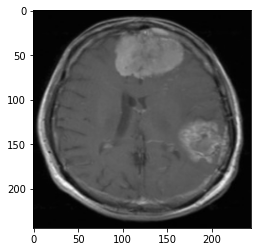

1
1


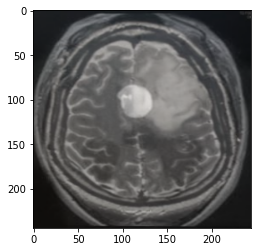

1
1


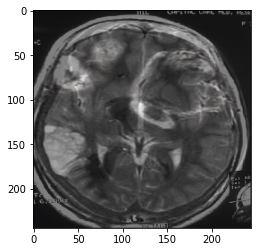

1
1


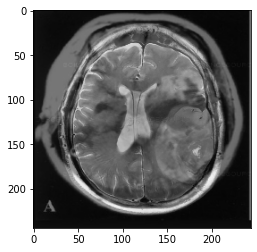

1
1


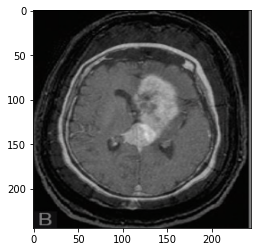

1
1


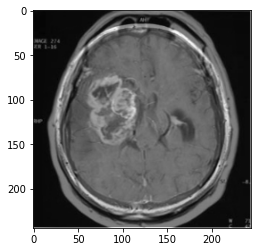

1
1


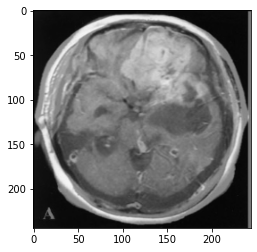

1
1


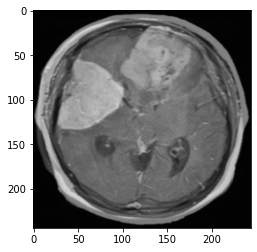

1
1


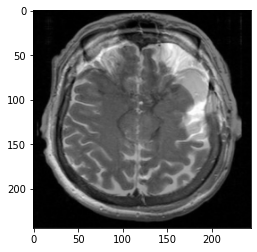

1
1


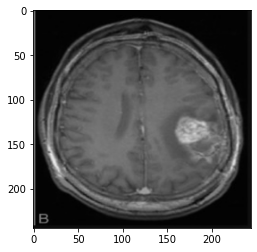

1
1


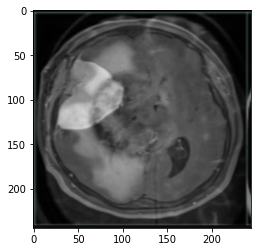

1
1


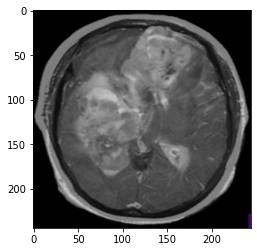

1
1


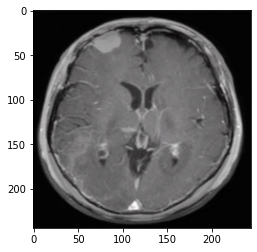

1
1


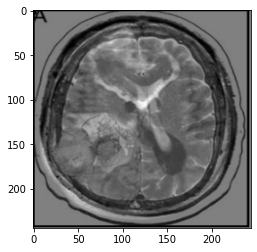

1
1


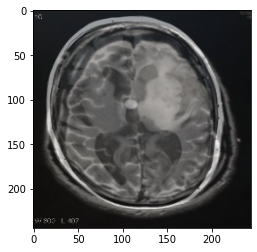

1
1


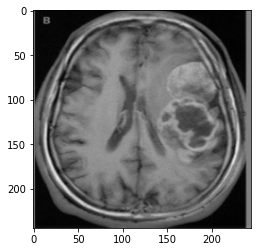

1
1


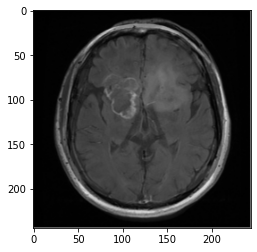

1
1


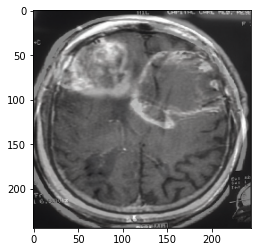

1
1


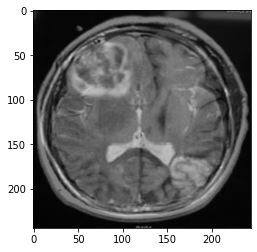

1
1


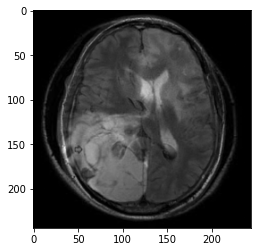

1
1


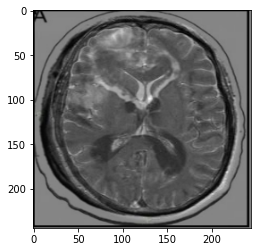

1
1


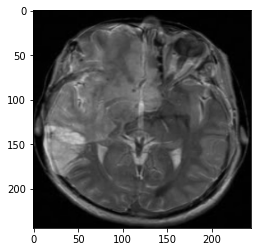

1
1


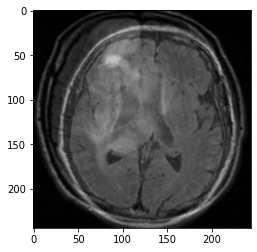

1
1


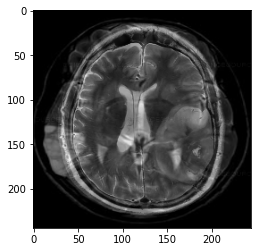

1
1


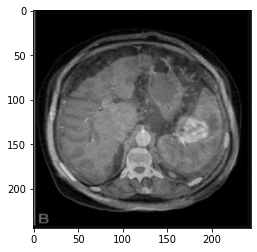

1
1


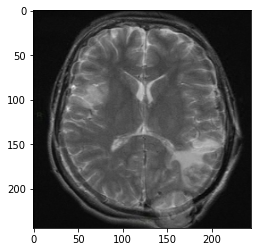

1
1


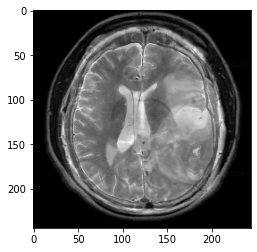

1
1


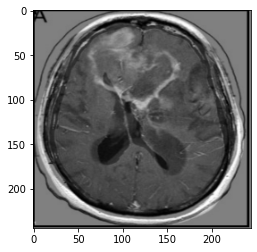

1
1


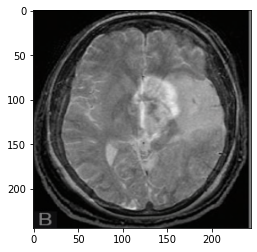

1
1


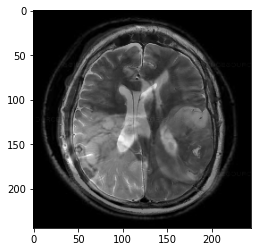

1
1


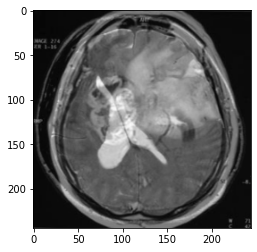

1
1


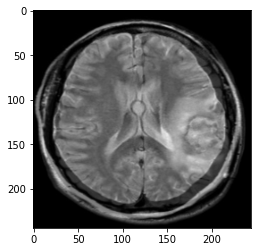

1
1


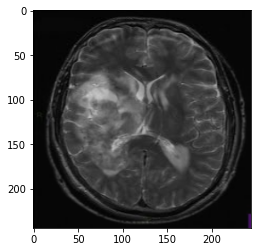

1
1


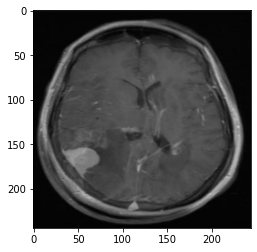

1
1


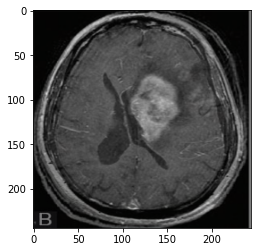

1
1


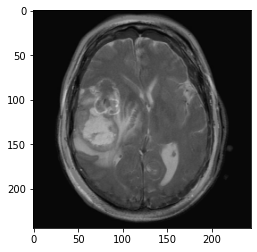

1
1


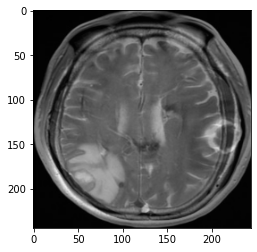

1
1


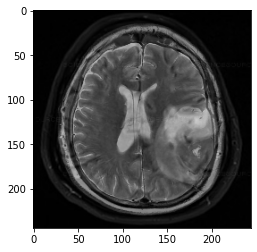

1
1


KeyboardInterrupt: ignored

In [ ]:
import numpy as np 
from os import listdir
from os.path import isfile, join
import cv2
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import sys
import shutil
import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras import backend as K
import pandas as pd
from sklearn.metrics import classification_report
from numpy.random import seed
from matplotlib import pyplot
from numpy import expand_dims
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
import sklearn
import datetime, os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import datetime as datetime
import tensorflow
tensorflow.random.set_seed(1234)



path='/content/drive/My Drive/Datasets/'
Dataset='Original244'
batch_size=32
imagex=[]
labx=[]
imagey=[]
laby=[]
def load_data_training_and_test(datasetname):
        npzfile=np.load(path+datasetname+'training_data.npz')
        train=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'training_labels.npz')
        train_labels=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'testing_data.npz')
        test=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'testing_labels.npz')
        test_labels=npzfile['arr_0']    
        return (train,train_labels),(test,test_labels)

(x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset)



y_train=y_train.reshape(y_train.shape[0],1)
y_testing=y_testing.reshape(y_testing.shape[0],1)

x_train=x_train.astype('float32')
x_test=x_test.astype('float32')

x_train/=255
x_test/=255


history=model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test,y_testing),shuffle=True,callbacks=callbacks)


_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_testing, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

his_df=pd.DataFrame(history.history)

predicted_classes = model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)


target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_testing, predicted_classes, target_names=target_names))


# Sample pairing

import random
a=0
if y_train[0]==1:
  for i in enumerate(x_train):
      n=random. randint(1,90)

      print
      nn=random. randint(1,90)
      a=(x_train[n])
      print(y_train[n])
      b=(x_train[nn])
      print(y_train[nn])

      img_a_array = np.asarray(a)
      img_b_array = np.asarray(b)

      # mix two images
      mean_img = np.mean([img_a_array, img_b_array], axis=0)
      img = (np.uint8(mean_img))
      imagex.append(img)
      labx.append(1)
      pyplot.imshow(img)
      pyplot.show()
      a=+1
      if a==2: 
        break

b=0
if y_train[0]==0:
  for i in enumerate(x_train):
      n=random. randint(1,90)

      print
      nn=random. randint(1,90)
      a=(x_train[n])
      print(y_train[n])
      b=(x_train[nn])
      print(y_train[nn])

      img_a_array = np.asarray(a)
      img_b_array = np.asarray(b)

      # mix two images
      mean_img = np.mean([img_a_array, img_b_array], axis=0)
      img = (np.uint8(mean_img))
      imagex.append(img)
      labx.append(1)
      pyplot.imshow(img)
      pyplot.show()
      b=+1
      if b==2: 
        break


